# GROUP PROJECT - 2

In this notebook, it is presented process of building a model to see the prediction accuracy of model by using clean data of Project-1 'Fannie Mae Single-Family Loan Performance' dataset.

This notebook was prepared by Betul Ozkaldi.

**Project Goal**  

The purpose of this project is to develop a mortgage default model that will determine the probability of default for a mortgage loan with the information at the time of mortgage origination.

## **Read Data**  
Read in the model data file that you have cleaned for Group Project 1.  
- We will make sure that we read the zip code from csv file in string format, otherwise python code will read the zip code in a format that will delete leading zeros.

### Libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore') 

In [62]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import FunctionTransformer,PowerTransformer, StandardScaler,MinMaxScaler, OneHotEncoder
from scipy.stats import norm, probplot, boxcox
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve,precision_recall_curve
from sklearn.pipeline import Pipeline

In [4]:
df_sample = pd.read_csv('Clean_data_1.csv', dtype={'zip':str})
df_sample.head()

,loan_id,act_period,channel,orig_rate,orig_upb,orig_term,orig_date,first_pay,loan_age,rem_months,...,target,last_period,calc_age,age_dif,calc_rem_months,cscore_min,orig_val,Vintage,Prepay,Default
0,265674961865,2018-02-28,R,4.125,183000.0,360.0,2017-01-20,2017-03-20,12.0,348.0,...,A,NaN,14,2.0,348,767.0,435714.285714,2017,0,0
1,747888204871,2020-07-28,R,4.625,108000.0,360.0,2013-09-20,2013-11-20,81.0,279.0,...,A,NaN,83,2.0,279,763.0,158823.529412,2013,0,0
2,939243187741,2021-06-28,C,3.375,417000.0,360.0,2016-08-20,2016-10-20,57.0,303.0,...,D,2021-06-20,59,2.0,303,755.0,834000.000000,2016,0,1
3,492457754312,2012-12-28,C,2.750,393000.0,180.0,2012-08-20,2012-10-20,3.0,177.0,...,A,NaN,5,2.0,177,802.0,714545.454545,2012,0,0
4,99982734,2021-11-28,R,3.250,86000.0,360.0,2020-05-20,2020-07-20,17.0,343.0,...,A,NaN,19,2.0,343,701.0,90526.315789,2020,0,0





__ML Workflow:__

  EDA  
  Feature Engineering   
  Feature Selection   
  Model Selection  
  Model Evaluation  
  Model Deployment  
    
      

In [5]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557576 entries, 0 to 557575
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_id                        557576 non-null  int64  
 1   act_period                     557576 non-null  object 
 2   channel                        557576 non-null  object 
 3   orig_rate                      557576 non-null  float64
 4   orig_upb                       557576 non-null  float64
 5   orig_term                      557576 non-null  float64
 6   orig_date                      557576 non-null  object 
 7   first_pay                      557576 non-null  object 
 8   loan_age                       557576 non-null  float64
 9   rem_months                     557576 non-null  float64
 10  matr_dt                        379617 non-null  object 
 11  oltv                           557576 non-null  float64
 12  ocltv                         

## **Drop the Columns**

Drop the columns that we will not use as model features by following the reasons below for
your decision making:  
- <u>Data columns that contain future information:</u>    

       rem_months , calc_rem_months
- <u>Data columns that contain information about the target:</u>   

      act_period, dlq_status, zero_bal_code, zb_dte, target, act_period    
- <u>Data columns that contain date/loan identifier:</u>    

       orig_date, matr_dt, last_period, first_pay
- <u>Data columns that will create high cardinality and multicolinearty:</u>   

      msa, zip

In [6]:
cols_to_drop = ['rem_months','dlq_status','zero_bal_code','orig_date','calc_rem_months','loan_id','act_period',
                'first_pay','matr_dt','msa','zip','zb_dte','target','last_period']

df_sample.drop(cols_to_drop, axis=1, inplace=True)

In [7]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557576 entries, 0 to 557575
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        557576 non-null  object 
 1   orig_rate                      557576 non-null  float64
 2   orig_upb                       557576 non-null  float64
 3   orig_term                      557576 non-null  float64
 4   loan_age                       557576 non-null  float64
 5   oltv                           557576 non-null  float64
 6   ocltv                          557576 non-null  float64
 7   num_bo                         557576 non-null  float64
 8   dti                            557576 non-null  float64
 9   cscore_b                       557576 non-null  float64
 10  cscore_c                       557576 non-null  float64
 11  first_flag                     557576 non-null  object 
 12  purpose                       

In [8]:
df_sample['loan_age']

0          12.0
1          81.0
2          57.0
3           3.0
4          17.0
          ...  
557571     10.0
557572     66.0
557573     27.0
557574     10.0
557575    183.0
Name: loan_age, Length: 557576, dtype: float64

## **Feature Engineering**

### Correlation Matrix - sns.Heatmap
- Redundant Features: Although some features are highly relevant to our target variable, they might be redundant. Any two independent variables are considered to be redundant if they are highly correlated. This causes unnecessary time and space wastage. The redundancy between two variables can be found using correlation.

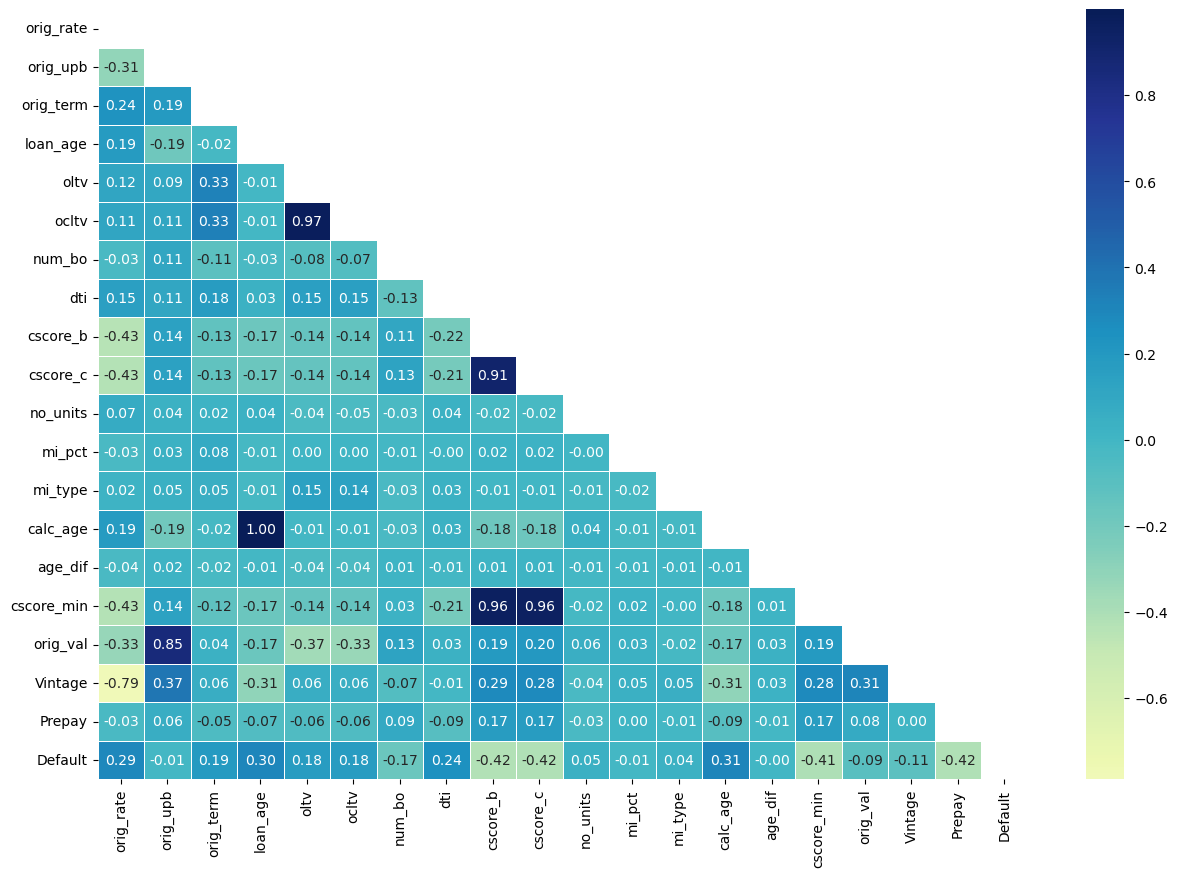

In [9]:
corr_matrix = df_sample.corr()
fig, ax =plt.subplots(figsize=(15,10))
matrix =np.triu(df_sample.corr())
ax =sns.heatmap(corr_matrix, annot= True, linewidths=0.5, fmt='.2f', cmap='YlGnBu', center=0, mask=matrix)

We can observe highly correlation between:  
    - cscore_c and cscore_b  
    - cscore_min is correlated with cscore_c and cscore_b  
    - loan_age and calc_age  
    - oltv and ocltv       
We can drop cscore_min. It is already derived from cscore_c and cscore_b. For to get rid of unnecessary time and space wastage. 

- oltv and ocltv are related in their definition and two of the most important attributes.  

_Original Loan to Value Ratio (LTV)_: The ratio, expressed as a percentage, obtained by dividing the amount of the loan at origination by the value of the property.

_Original Combined Loan to Value Ratio (CLTV)_: The ratio, expressed as a percentage, obtained by dividing the amount of all known outstanding loans at origination by the value of the property.

In [10]:
df_sample.drop('cscore_min',axis=1,inplace =True)

In [11]:
df_sample.drop('calc_age', axis=1, inplace=True)

In [12]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557576 entries, 0 to 557575
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        557576 non-null  object 
 1   orig_rate                      557576 non-null  float64
 2   orig_upb                       557576 non-null  float64
 3   orig_term                      557576 non-null  float64
 4   loan_age                       557576 non-null  float64
 5   oltv                           557576 non-null  float64
 6   ocltv                          557576 non-null  float64
 7   num_bo                         557576 non-null  float64
 8   dti                            557576 non-null  float64
 9   cscore_b                       557576 non-null  float64
 10  cscore_c                       557576 non-null  float64
 11  first_flag                     557576 non-null  object 
 12  purpose                       

In [13]:
file_path ='ready_data_1.csv'
df_sample.to_csv(file_path, index= False)

In [20]:
df_sample= pd.read_csv('ready_data_1.csv')

In [58]:
df_sample.isnull().sum().sum()

0

### Transformation
-  Some Machine Learning models, like Linear and Logistic regression, assume that the variables follow a normal distribution. 
- By applying some transformations to these skewed variables, we can map this skewed distribution to a normal distribution so, this can increase the performance of our models.    
- We can see the distribution only in numerical data

_Log Transformation_: This transformation is mostly applied to right-skewed data.Convert data from addictive Scale to multiplicative scale i,e, linearly distributed data.  
_Square Transformation_:This transformation mostly applies to left-skewed data.

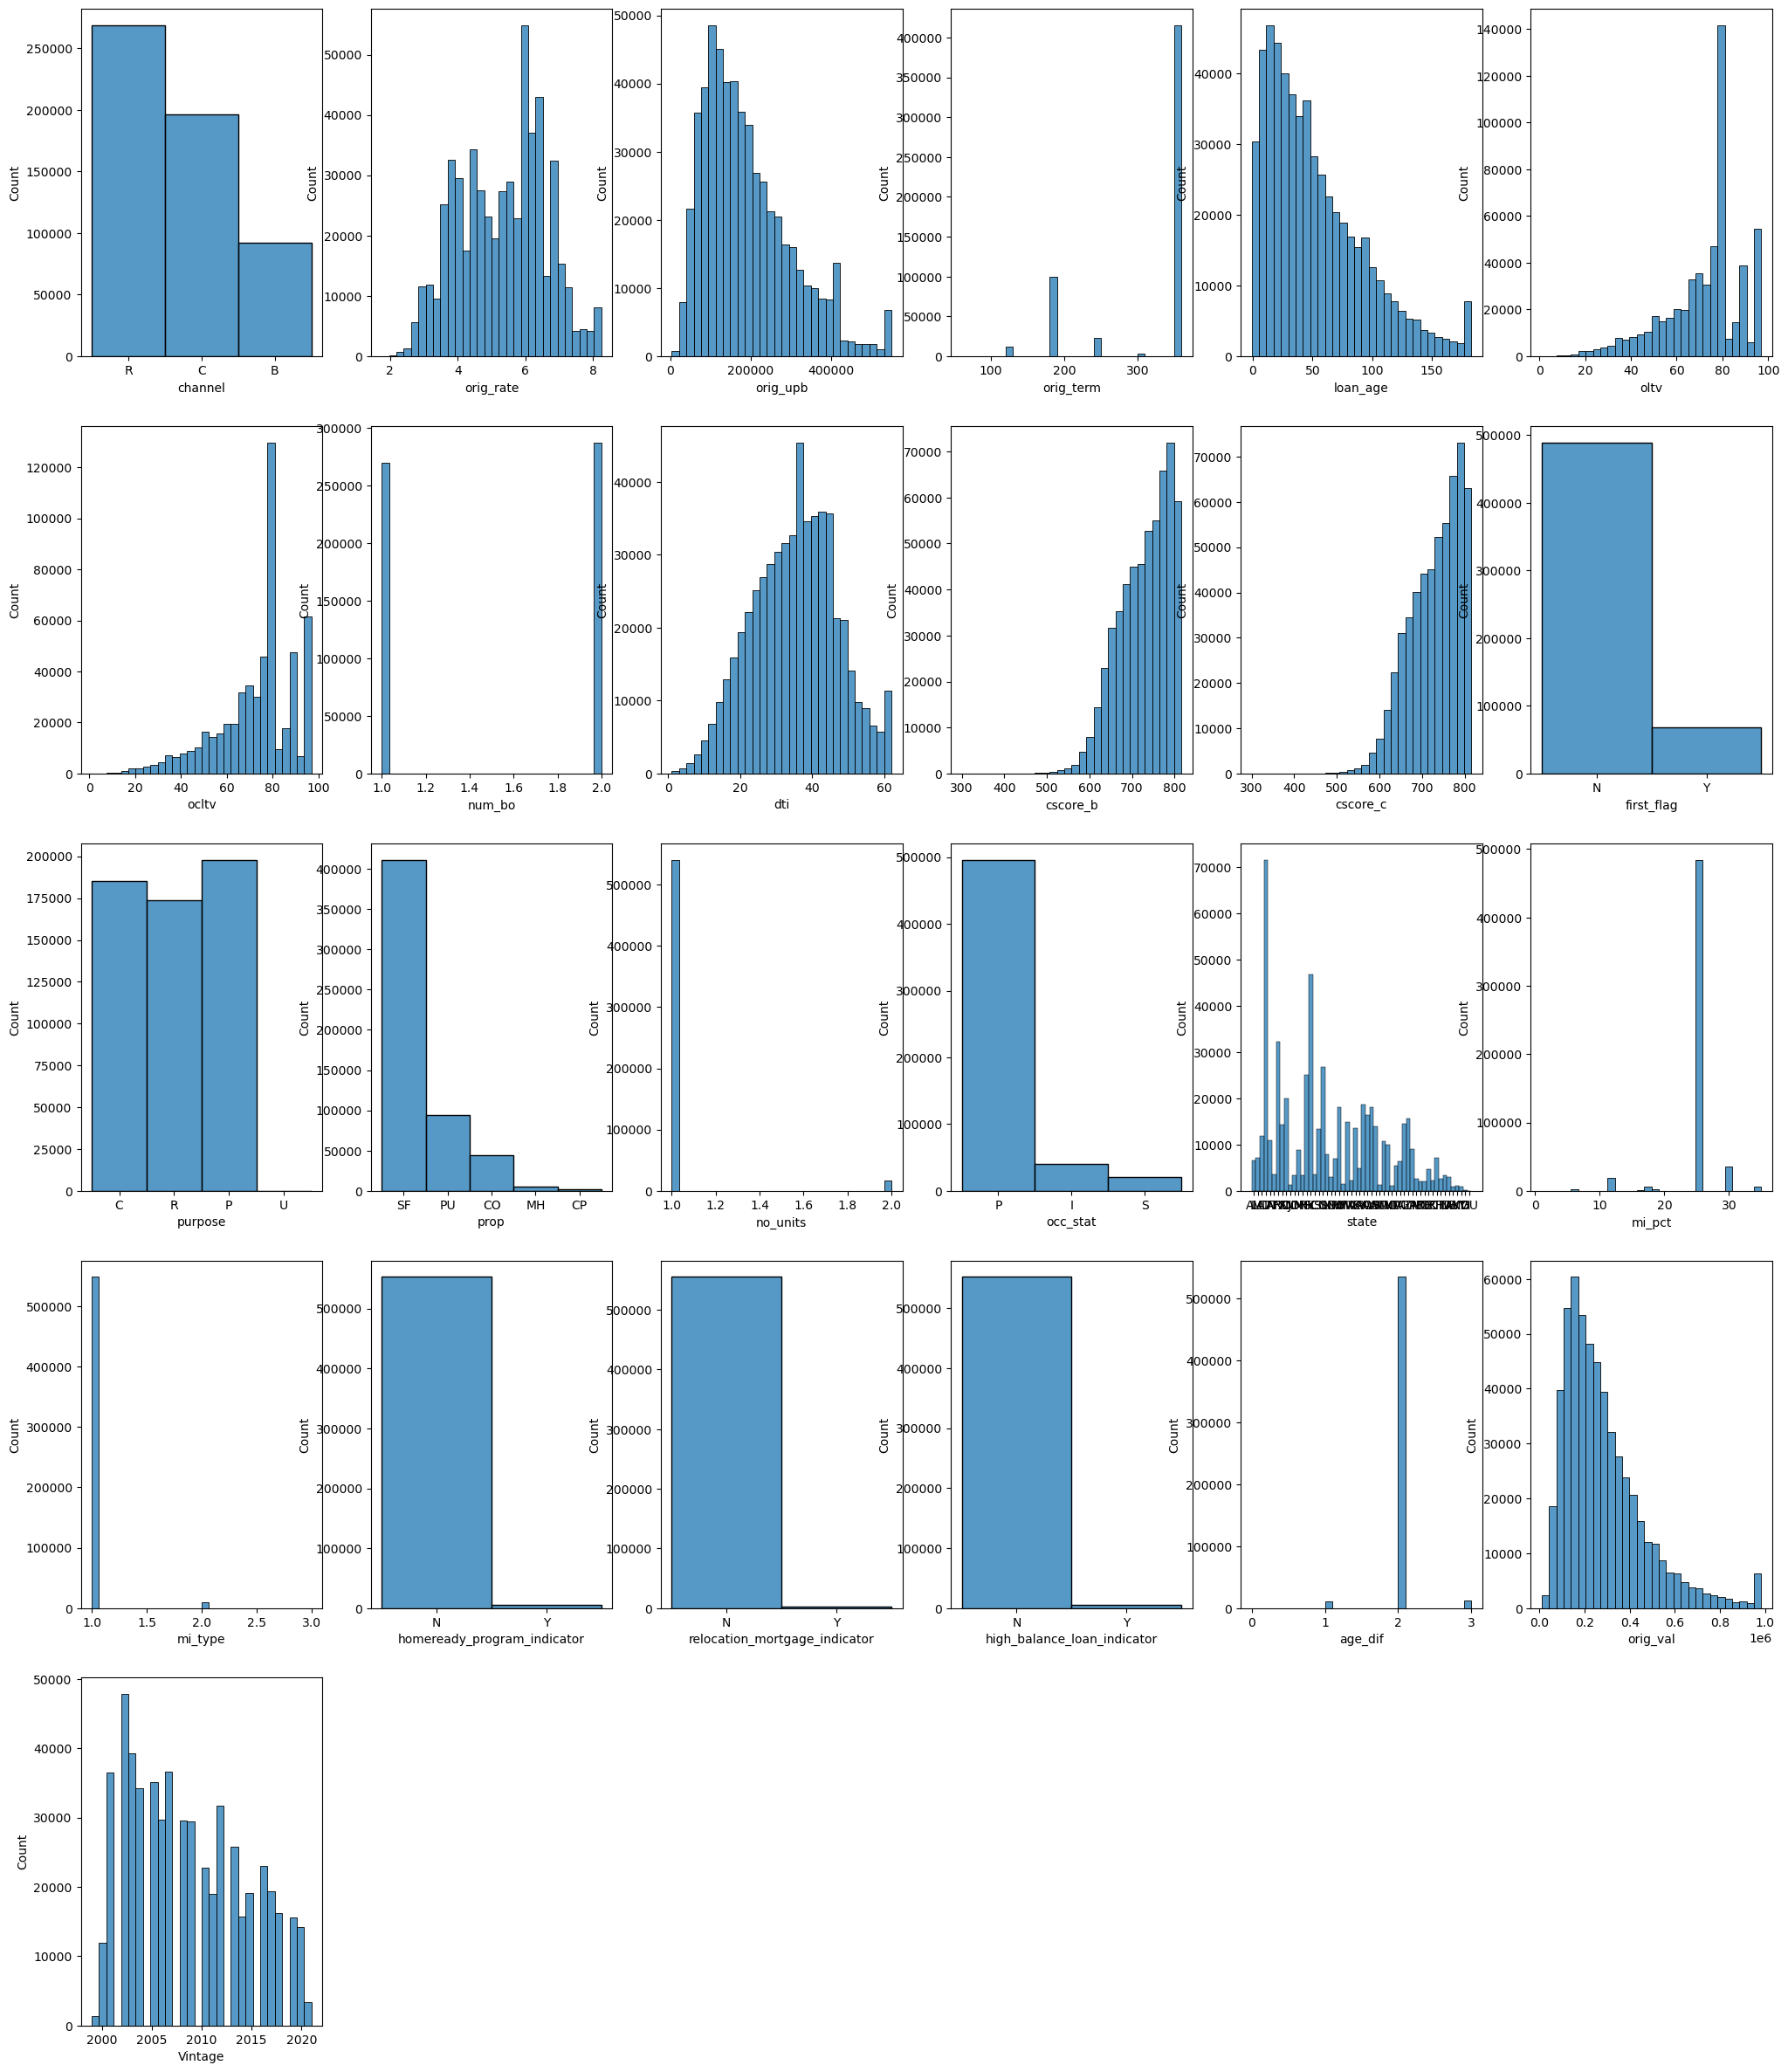

In [16]:
plt.figure(figsize=(25,30))

for i in range(len(df_sample.keys())-2):
    plt.subplot(5, 6, i+1)
    sns.histplot(df_sample.iloc[:, i], bins=30)

In [21]:
df = df_sample.copy()

**Loan Age**: The number of calendar months since the mortgage loan's origination date. For purposes of calculating this data element, origination means the date on which the first full month of interest begins to accrue.

#### Square Root Transformation  
- Applying the square root of the values can help reduce the skewness of left-skewed data. 

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557576 entries, 0 to 557575
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        557576 non-null  object 
 1   orig_rate                      557576 non-null  float64
 2   orig_upb                       557576 non-null  float64
 3   orig_term                      557576 non-null  float64
 4   loan_age                       557576 non-null  float64
 5   oltv                           557576 non-null  float64
 6   ocltv                          557576 non-null  float64
 7   num_bo                         557576 non-null  float64
 8   dti                            557576 non-null  float64
 9   cscore_b                       557576 non-null  float64
 10  cscore_c                       557576 non-null  float64
 11  first_flag                     557576 non-null  object 
 12  purpose                       

In [61]:
df['loan_age'].isnull().sum()

0

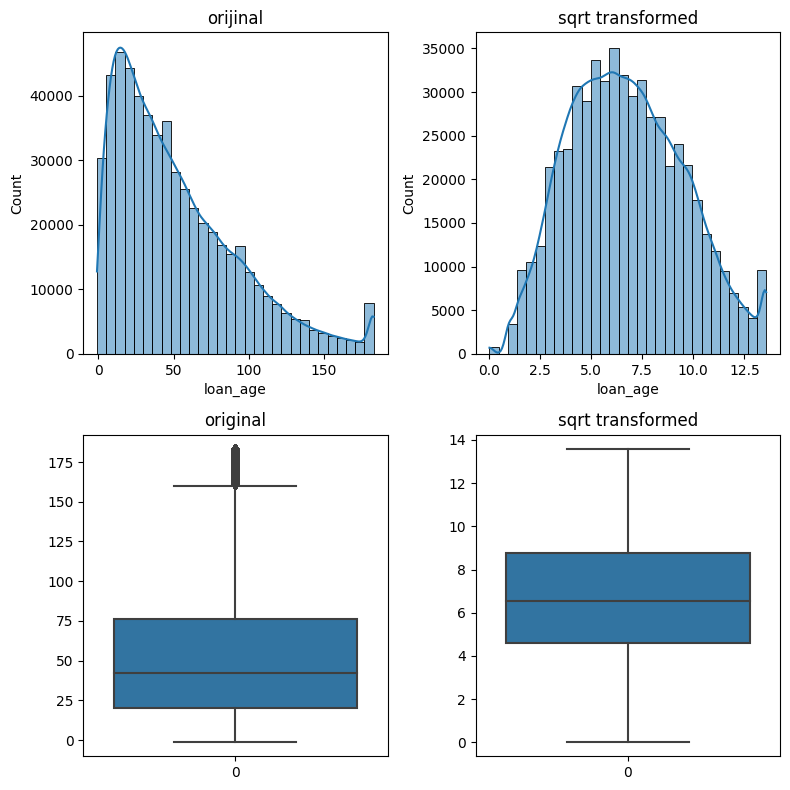

In [62]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df['loan_age'], bins=30, kde=True)
plt.title('orijinal')
plt.subplot(2,2,2)
shifted_data = df['loan_age']-df['loan_age'].min()+0.001 #substract min value and add small value due to be not equal =0
sns.histplot(np.sqrt(shifted_data), bins=30, kde=True)
plt.title('sqrt transformed')
plt.subplot(2,2,3)
sns.boxplot(df['loan_age'])
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(shifted_data))
plt.title('sqrt transformed')
plt.tight_layout();

In [63]:
df['loan_age'] = np.sqrt(shifted_data)
df['loan_age'].isnull().sum()

0

In [64]:
df['loan_age']

0          3.605690
1          9.055440
2          7.615839
3          2.000250
4          4.242759
            ...    
557571     3.316776
557572     8.185414
557573     5.291597
557574     3.316776
557575    13.564697
Name: loan_age, Length: 557576, dtype: float64

In [65]:
#Checking negative values
for values in df['loan_age'].values:
    if values<0:
        print(values)

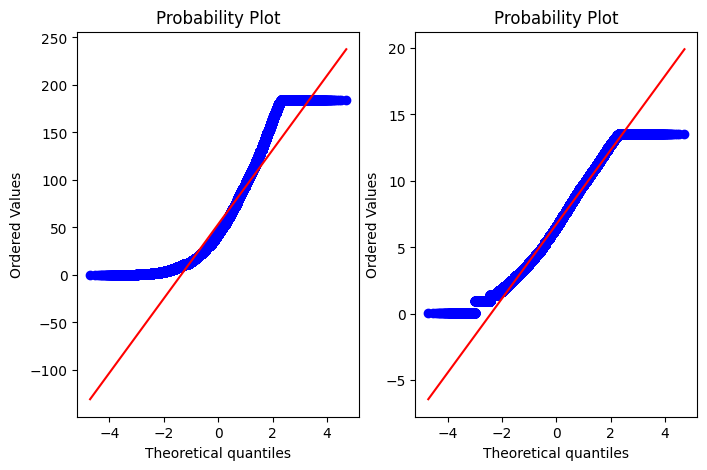

In [66]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
probplot(shifted_data, plot=plt)
plt.subplot(1,2,2)
probplot(df['loan_age'], plot=plt);

- **Apply transformation for other skewed datas**

In [67]:
df['orig_val'].isnull().sum()

0

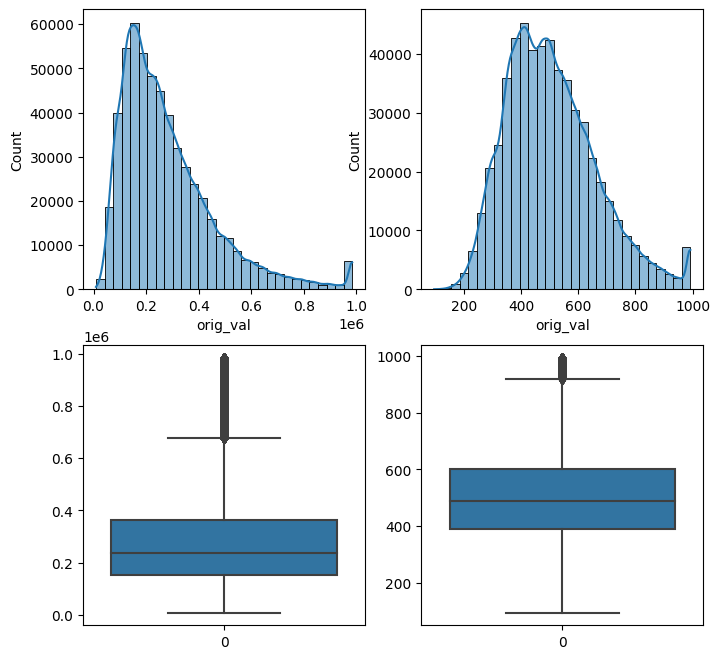

In [68]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df['orig_val'], bins=30, kde= True)
plt.subplot(2,2,2)
sns.histplot(np.sqrt(df['orig_val']), bins=30 , kde= True)
plt.subplot(2,2,3)
sns.boxplot(df['orig_val'])
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(df['orig_val']));

In [69]:
df['orig_val'] = np.sqrt(df['orig_val'])

In [70]:
df['orig_val'].isnull().sum()

0

**Original UPB**: The dollar amount of the loan as stated on the note at the time the loan was originated.

In [71]:
df['orig_upb'].isnull().sum()

0

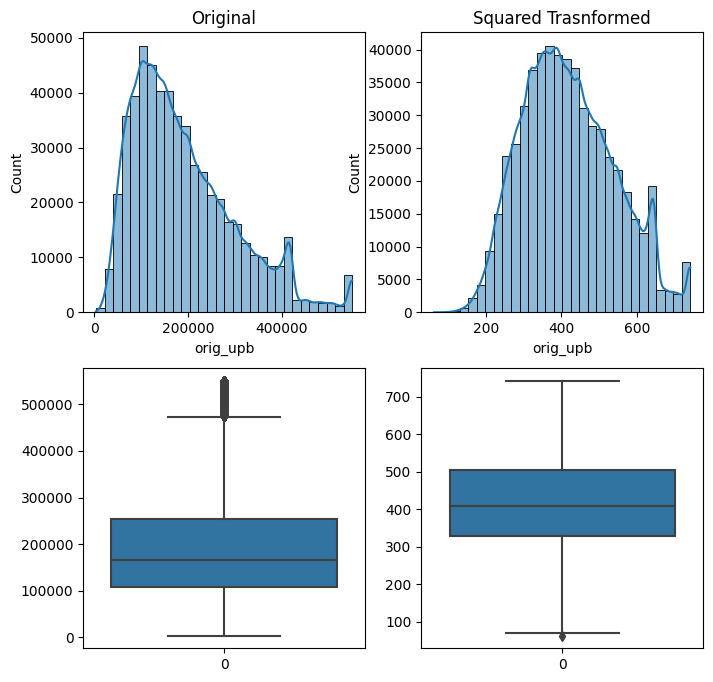

In [72]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df['orig_upb'], bins=30, kde= True)
plt.title('Original')
plt.subplot(2,2,2)
sns.histplot(np.sqrt(df['orig_upb']), bins=30 , kde= True)
plt.title('Squared Trasnformed')
plt.subplot(2,2,3)
sns.boxplot(df['orig_upb'])
plt.subplot(2,2,4)
sns.boxplot(np.sqrt(df['orig_upb']));

In [73]:
df['orig_upb']= np.sqrt(df['orig_upb'])

In [74]:
df['orig_upb'].isnull().sum()

0

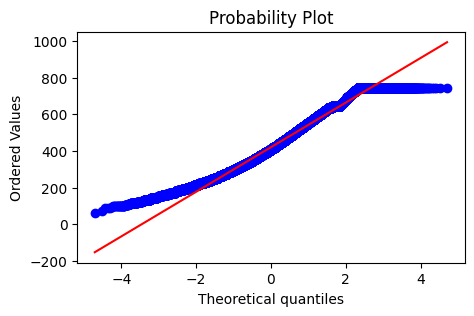

In [75]:
plt.figure(figsize=(5,3))
probplot(df['orig_upb'].ravel(), plot=plt);

- __**Left skewed data transformation**__

#### Yeo-Johnson Transformation:
- We will handle left skewed columns' data with  Yeo-Johnson Transformation  
_The Yeo-Johnson transformation_:It applies a family of power transformations to the data, including both positive and negative powers. It works by applying a different power transformation to positive values, negative values, and zero values. This allows for more flexibility and improved handling of non-normal data.

__**OLTV**__

In [76]:
df['oltv'].isnull().sum()

0

In [77]:
df['oltv'][:5]

0    42.0
1    68.0
2    50.0
3    55.0
4    95.0
Name: oltv, dtype: float64

In [78]:
df_oltv= df['oltv']
transformer= PowerTransformer(method = 'yeo-johnson')
oltv =df['oltv'].values.reshape(-1,1) # reshape 2dim array
transformed_oltv = transformer.fit_transform(oltv)

In [79]:
#  #return 1 dim array
df['oltv'] = transformed_oltv.ravel()

In [80]:
#df['oltv']

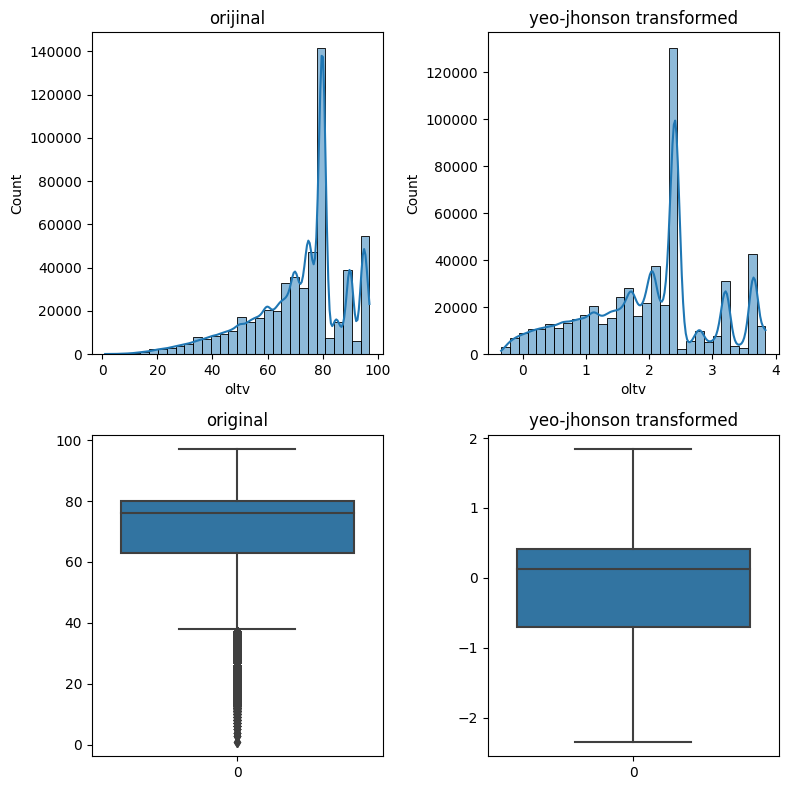

In [82]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df_oltv, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df['oltv']+2, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_oltv)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df['oltv'])
plt.title('yeo-jhonson transformed')
plt.tight_layout();

In [83]:
df['oltv'].isnull().sum()

0

 __**OCLTV**__

In [84]:
df['ocltv'][:5]

0    42.0
1    68.0
2    67.0
3    55.0
4    95.0
Name: ocltv, dtype: float64

In [85]:
df_ocltv= df['ocltv']
transformer= PowerTransformer(method = 'yeo-johnson')
ocltv =df['ocltv'].values.reshape(-1,1) # reshape 2dim array
transformed_ocltv = transformer.fit_transform(ocltv)

In [86]:
df['ocltv'] = transformed_ocltv.ravel()

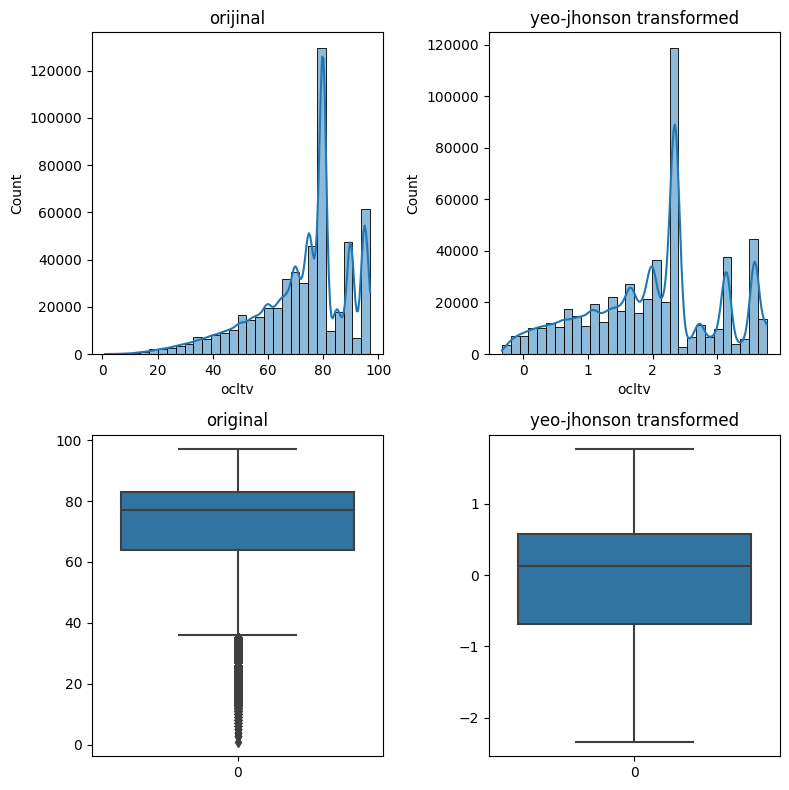

In [87]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df_ocltv, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df['ocltv']+2, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_ocltv)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df['ocltv'])
plt.title('yeo-jhonson transformed')
plt.tight_layout();

In [88]:
df['ocltv'].isnull().sum()

0

__**Cscore_c**__

In [89]:
df['cscore_c'][:5]

0    767.0
1    770.0
2    755.0
3    802.0
4    701.0
Name: cscore_c, dtype: float64

In [90]:
df_cscore_c=df['cscore_c']
transformer= PowerTransformer(method = 'yeo-johnson')
cscore_c =df['cscore_c'].values.reshape(-1,1) # reshape 2dim array
transformed_cscore_c = transformer.fit_transform(cscore_c)

In [91]:
df['cscore_c'] = transformed_cscore_c.ravel()

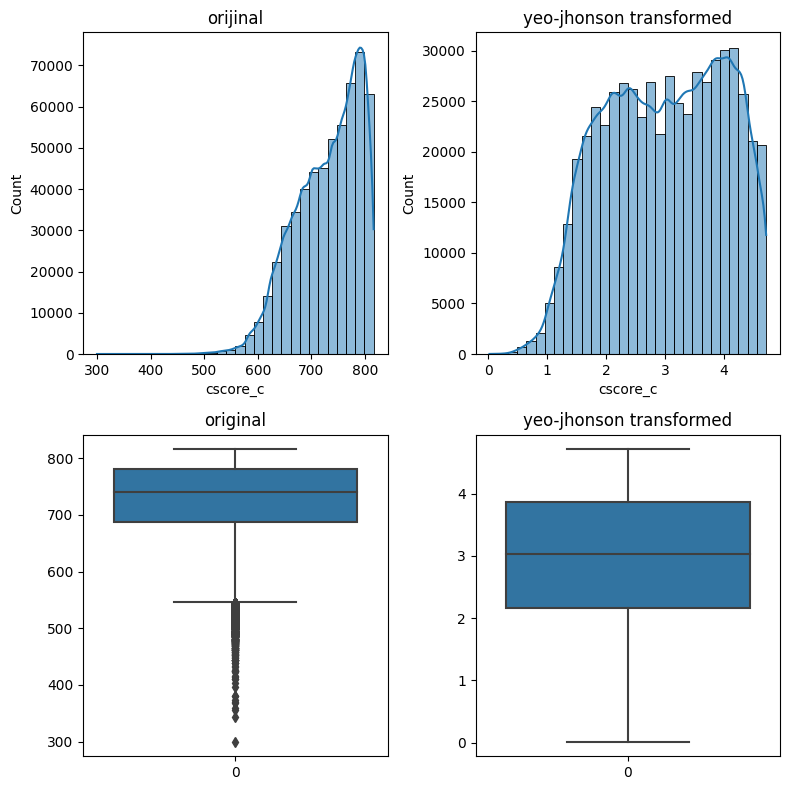

In [92]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df_cscore_c, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df['cscore_c']+3, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_cscore_c)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df['cscore_c']+3)
plt.title('yeo-jhonson transformed')
plt.tight_layout();

In [48]:
df['cscore_c'].isnull().sum()

0

__**Cscore_b**__

In [49]:
df['cscore_b'][:5]

0    769.0
1    763.0
2    785.0
3    802.0
4    725.0
Name: cscore_b, dtype: float64

In [50]:
df_cscore_b=df['cscore_b']
transformer= PowerTransformer(method = 'yeo-johnson')
cscore_b =df['cscore_b'].values.reshape(-1,1) # reshape 2dim array
transformed_cscore_b = transformer.fit_transform(cscore_b)

In [51]:
df['cscore_b'] = transformed_cscore_b.ravel()

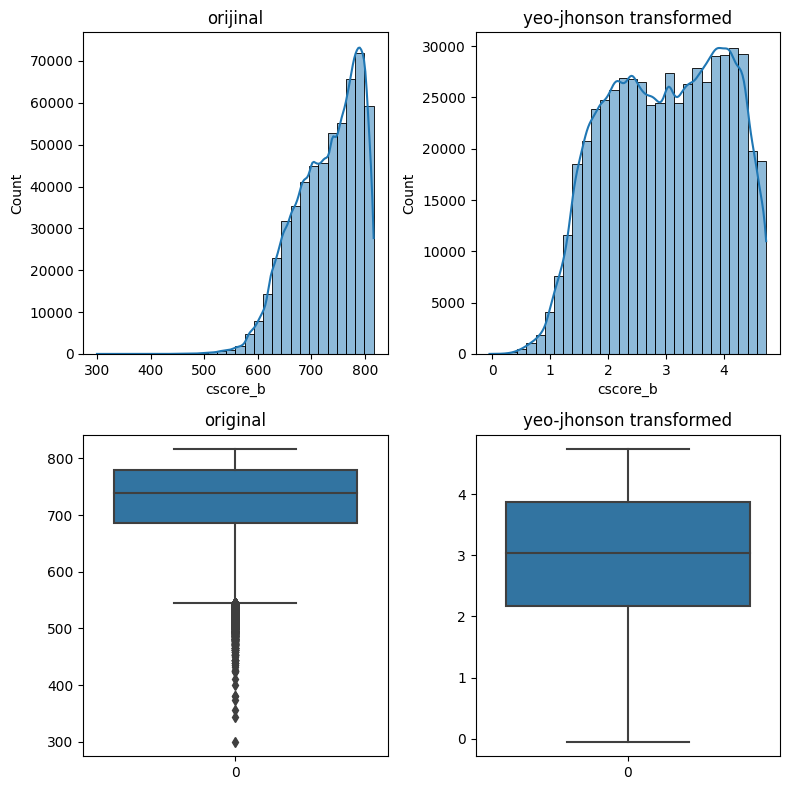

In [53]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.histplot(df_cscore_b, bins=30, kde= True)
plt.title('orijinal')
plt.subplot(2,2,2)
sns.histplot(df['cscore_b']+3, bins=30, kde=True)
plt.title('yeo-jhonson transformed')
plt.subplot(2,2,3)
sns.boxplot(df_cscore_b)
plt.title('original')
plt.subplot(2,2,4)
sns.boxplot(df['cscore_b']+ 3)
plt.title('yeo-jhonson transformed')
plt.tight_layout();

#### Conclusion  
For right skewed data;  
   - I applied np.sqrt transformation and I converted them to the normal distribution with positive reasonable values.  
   
For left skewed data;   
- I applied Yeo-Jhonson transformation and I converted them to the normal distribution.


In [93]:
df.isnull().sum()

channel                          0
orig_rate                        0
orig_upb                         0
orig_term                        0
loan_age                         0
oltv                             0
ocltv                            0
num_bo                           0
dti                              0
cscore_b                         0
cscore_c                         0
first_flag                       0
purpose                          0
prop                             0
no_units                         0
occ_stat                         0
state                            0
mi_pct                           0
mi_type                          0
homeready_program_indicator      0
relocation_mortgage_indicator    0
high_balance_loan_indicator      0
age_dif                          0
orig_val                         0
Vintage                          0
Prepay                           0
Default                          0
dtype: int64

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557576 entries, 0 to 557575
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        557576 non-null  object 
 1   orig_rate                      557576 non-null  float64
 2   orig_upb                       557576 non-null  float64
 3   orig_term                      557576 non-null  float64
 4   loan_age                       557576 non-null  float64
 5   oltv                           557576 non-null  float64
 6   ocltv                          557576 non-null  float64
 7   num_bo                         557576 non-null  float64
 8   dti                            557576 non-null  float64
 9   cscore_b                       557576 non-null  float64
 10  cscore_c                       557576 non-null  float64
 11  first_flag                     557576 non-null  object 
 12  purpose                       

#### Save df to csv file:

In [95]:
file_path = 'ready_data_2.csv'
df.to_csv(file_path,index=False)

In [64]:
# Load your dataset
dataset = pd.read_csv('ready_data_2.csv')
dataset.head()

,channel,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,cscore_b,...,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,age_dif,orig_val,Vintage,Prepay,Default
0,R,4.125,427.784993,360.0,3.605690,-1.655310,-1.678221,2.0,43.0,769.0,...,25.0,1.0,N,N,N,2.0,660.086574,2017,0,0
1,R,4.625,328.633535,360.0,9.055440,-0.403892,-0.457299,2.0,48.0,763.0,...,25.0,1.0,N,N,N,2.0,398.526698,2013,0,0
2,C,3.375,645.755372,360.0,7.615839,-1.343351,-0.517257,2.0,41.0,785.0,...,25.0,1.0,N,N,N,2.0,913.236005,2016,0,1
3,C,2.750,626.897121,180.0,2.000250,-1.115887,-1.154291,1.0,15.0,802.0,...,25.0,1.0,N,N,N,2.0,845.307905,2012,0,0
4,R,3.250,293.257566,360.0,4.242759,1.655819,1.578316,2.0,27.0,725.0,...,25.0,1.0,Y,N,N,2.0,300.875914,2020,0,0


In [23]:
dataset.isnull().sum().sum()

0

## **Split the Dataset**
- When creating our hold-out dataset we need to think about our business purpose. We would
like to use this model to understand the default probability of future originations. Therefore it
makes sense to evaluate the performance of the model for future acquisitions. With this
reasoning, **split the dataset based on vintage (origination date)**  
- From our EDA the default rate stabilizes after 3-4 years. So the vintages chosen should not be later than 2016. From
2009 to 2012 the mortgage market was right after recession and it was overly conservative so
we would like to include those vintages in our model estimation.

In [66]:
dataset['Vintage']

0         2017
1         2013
2         2016
3         2012
4         2020
          ... 
557571    2012
557572    2005
557573    2019
557574    2004
557575    2002
Name: Vintage, Length: 557576, dtype: int64

**Test Set**

In [67]:
holdout_years_index = dataset[dataset['Vintage'] >= 2014].index
holdout_years_index

Index([     0,      2,      4,      5,      6,     10,     12,     20,     23,
           26,
       ...
       557527, 557533, 557537, 557538, 557544, 557558, 557565, 557566, 557570,
       557573],
      dtype='int64', length=126621)

In [68]:
holdout_data = dataset.loc[holdout_years_index]

In [69]:
holdout_data['Vintage']

0         2017
2         2016
4         2020
5         2014
6         2017
          ... 
557558    2020
557565    2016
557566    2017
557570    2015
557573    2019
Name: Vintage, Length: 126621, dtype: int64

In [70]:
holdout_data['Default'].value_counts(normalize=True)

Default
0    0.794418
1    0.205582
Name: proportion, dtype: float64

In [71]:
X_holdout = holdout_data.drop('Default', axis=1)
y_holdout = holdout_data['Default']

In [72]:
X_holdout.shape, y_holdout.shape

((126621, 26), (126621,))

**Train Set**

In [73]:
train_data= dataset.drop(holdout_years_index)

In [74]:
train_data['Default'].value_counts(normalize=True)

Default
0    0.693759
1    0.306241
Name: proportion, dtype: float64

In [75]:
train_data['Vintage']

1         2013
3         2012
7         2004
8         2010
9         2007
          ... 
557569    2010
557571    2012
557572    2005
557574    2004
557575    2002
Name: Vintage, Length: 430955, dtype: int64

In [76]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430955 entries, 1 to 557575
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   channel                        430955 non-null  object 
 1   orig_rate                      430955 non-null  float64
 2   orig_upb                       430955 non-null  float64
 3   orig_term                      430955 non-null  float64
 4   loan_age                       430955 non-null  float64
 5   oltv                           430955 non-null  float64
 6   ocltv                          430955 non-null  float64
 7   num_bo                         430955 non-null  float64
 8   dti                            430955 non-null  float64
 9   cscore_b                       430955 non-null  float64
 10  cscore_c                       430955 non-null  float64
 11  first_flag                     430955 non-null  object 
 12  purpose                        4309

In [77]:
X_train = train_data.drop('Default', axis=1)
y_train = train_data['Default']

In [78]:
X_train.columns

Index(['channel', 'orig_rate', 'orig_upb', 'orig_term', 'loan_age', 'oltv',
       'ocltv', 'num_bo', 'dti', 'cscore_b', 'cscore_c', 'first_flag',
       'purpose', 'prop', 'no_units', 'occ_stat', 'state', 'mi_pct', 'mi_type',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator', 'age_dif', 'orig_val', 'Vintage',
       'Prepay'],
      dtype='object')

In [79]:
X_train.shape, y_train.shape

((430955, 26), (430955,))

In [36]:
# train set Numerical Columns
df_num_features = train_data.select_dtypes(exclude='object')
df_X_train_numerical= df_num_features.iloc[:,:-3] #last three target

# train set Categorical Columns
df_X_train_categorical = train_data.select_dtypes(exclude='number')

In [37]:
df_X_train_numerical.head()

,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,cscore_b,cscore_c,no_units,mi_pct,mi_type,age_dif,orig_val
1,4.625,328.633535,360.0,9.055440,-0.403892,-0.457299,2.0,48.0,763.0,0.629736,1.0,25.0,1.0,2.0,398.526698
3,2.750,626.897121,180.0,2.000250,-1.115887,-1.154291,1.0,15.0,802.0,1.361054,1.0,25.0,1.0,2.0,845.307905
7,6.125,324.037035,360.0,3.316776,0.412641,0.346950,2.0,25.0,649.0,0.262125,1.0,25.0,1.0,2.0,362.284419
8,5.000,309.838668,360.0,9.643703,-2.074613,-2.081010,1.0,42.0,687.0,-0.833781,1.0,25.0,1.0,2.0,596.284794
9,6.875,591.607978,360.0,12.328869,-0.278571,-0.334158,2.0,26.0,695.0,-0.147596,2.0,25.0,1.0,2.0,707.106781


In [38]:
df_X_train_categorical.head()

,channel,first_flag,purpose,prop,occ_stat,state,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator
1,R,N,R,SF,P,LA,N,N,N
3,C,N,R,PU,P,CA,N,N,N
7,R,N,P,SF,P,NC,N,N,N
8,C,N,C,SF,P,NJ,N,N,N
9,B,N,C,SF,I,DC,N,N,N


### **Training Set Scaling and OHE**
#### MinMax Scaling

In [39]:
# SS for train set numerical features
scaler = MinMaxScaler()

X_train_num_scaled = scaler.fit_transform(df_X_train_numerical)
df_X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = df_X_train_numerical.columns)
df_X_train_num_scaled.head()

,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,cscore_b,cscore_c,no_units,mi_pct,mi_type,age_dif,orig_val
0,0.431373,0.384438,1.0,0.666797,0.463436,0.457973,1.0,0.770492,0.897287,0.769066,0.0,0.705882,0.0,0.666667,0.337489
1,0.137255,0.829004,0.4,0.145468,0.293232,0.287742,0.0,0.229508,0.972868,0.924758,0.0,0.705882,0.0,0.666667,0.836437
2,0.666667,0.377587,1.0,0.242750,0.658629,0.654401,1.0,0.393443,0.676357,0.690805,0.0,0.705882,0.0,0.666667,0.297015
3,0.490196,0.356424,1.0,0.710266,0.064048,0.061402,0.0,0.672131,0.750000,0.457496,0.0,0.705882,0.0,0.666667,0.558337
4,0.784314,0.776405,1.0,0.908681,0.493394,0.488049,1.0,0.409836,0.765504,0.603579,1.0,0.705882,0.0,0.666667,0.682099


#### OHE for training set 

In [40]:
ohe = OneHotEncoder(sparse= False)
X_train_cat_encoded = ohe.fit_transform(df_X_train_categorical)

In [41]:
ohe.get_feature_names_out()

array(['channel_B', 'channel_C', 'channel_R', 'first_flag_N',
       'first_flag_Y', 'purpose_C', 'purpose_P', 'purpose_R', 'purpose_U',
       'prop_CO', 'prop_CP', 'prop_MH', 'prop_PU', 'prop_SF',
       'occ_stat_I', 'occ_stat_P', 'occ_stat_S', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_GU',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS',
       'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH',
       'state_OK', 'state_OR', 'state_PA', 'state_PR', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VI', 'state_VT', 'state_WA', 'state_WI',
       'state_WV', 'state_WY', 'homeready_program_indicato

In [42]:
type(X_train_cat_encoded)

numpy.ndarray

In [43]:
# convert to dataframe
df_X_train_cat_encoded =pd.DataFrame(X_train_cat_encoded, columns =ohe.get_feature_names_out())
df_X_train_cat_encoded.head()

,channel_B,channel_C,channel_R,first_flag_N,first_flag_Y,purpose_C,purpose_P,purpose_R,purpose_U,prop_CO,...,state_VT,state_WA,state_WI,state_WV,state_WY,homeready_program_indicator_N,relocation_mortgage_indicator_N,relocation_mortgage_indicator_Y,high_balance_loan_indicator_N,high_balance_loan_indicator_Y
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [44]:
df_X_train_cat_encoded['channel_C'].value_counts()

channel_C
0.0    274727
1.0    156228
Name: count, dtype: int64

### **Test Set Scaling and OHE**


In [45]:
# Numerical Columns
df_X_holdout_num_features = holdout_data.select_dtypes(exclude='object')
df_X_holdout_numerical= df_X_holdout_num_features.iloc[:,:-3]
# categorical Columns
df_X_holdout_categorical = holdout_data.select_dtypes(exclude='number')

In [46]:
df_X_holdout_numerical.columns

Index(['orig_rate', 'orig_upb', 'orig_term', 'loan_age', 'oltv', 'ocltv',
       'num_bo', 'dti', 'cscore_b', 'cscore_c', 'no_units', 'mi_pct',
       'mi_type', 'age_dif', 'orig_val'],
      dtype='object')

In [47]:
df_X_holdout_categorical.columns

Index(['channel', 'first_flag', 'purpose', 'prop', 'occ_stat', 'state',
       'homeready_program_indicator', 'relocation_mortgage_indicator',
       'high_balance_loan_indicator'],
      dtype='object')

#### MinMax Scaling for holdout set

In [48]:
scaler = MinMaxScaler()

#fitting part with X_train
scaler.fit(df_X_train_numerical)

# transform part with holdout 
X_holdout_num_scaled = scaler.transform(df_X_holdout_numerical)
df_X_holdout_num_scaled = pd.DataFrame(X_holdout_num_scaled, columns = df_X_holdout_numerical.columns)
df_X_holdout_num_scaled.head()

,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,cscore_b,cscore_c,no_units,mi_pct,mi_type,age_dif,orig_val
0,0.352941,0.532225,1.0,0.264099,0.164283,0.159778,1.0,0.688525,0.908915,0.755574,0.0,0.705882,0.0,0.666667,0.629589
1,0.235294,0.857113,1.0,0.560421,0.238857,0.443329,1.0,0.655738,0.939922,0.703406,0.0,0.705882,0.0,0.666667,0.912297
2,0.215686,0.331709,1.0,0.311174,0.955813,0.955147,1.0,0.426230,0.823643,0.501716,0.0,0.705882,0.0,0.666667,0.228436
3,0.450980,0.388953,1.0,0.504254,0.259881,0.254542,1.0,0.393443,0.709302,0.325506,0.0,0.705882,0.0,0.666667,0.406065
4,0.372549,0.612532,1.0,0.493358,0.955813,0.955147,0.0,0.639344,0.889535,0.720479,0.0,0.852941,0.0,0.666667,0.444307


#### One-Hot Encoding for  holdout set

In [49]:
ohe = OneHotEncoder(sparse= False, handle_unknown ='ignore')

# fit with train                                           
ohe.fit(df_X_train_categorical)
# transform with holdout
X_holdout_cat_encoded = ohe.transform(df_X_holdout_categorical)

In [50]:
ohe.get_feature_names_out()

array(['channel_B', 'channel_C', 'channel_R', 'first_flag_N',
       'first_flag_Y', 'purpose_C', 'purpose_P', 'purpose_R', 'purpose_U',
       'prop_CO', 'prop_CP', 'prop_MH', 'prop_PU', 'prop_SF',
       'occ_stat_I', 'occ_stat_P', 'occ_stat_S', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_GU',
       'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS',
       'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH',
       'state_OK', 'state_OR', 'state_PA', 'state_PR', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VI', 'state_VT', 'state_WA', 'state_WI',
       'state_WV', 'state_WY', 'homeready_program_indicato

In [51]:
df_X_holdout_cat_encoded =pd.DataFrame(X_holdout_cat_encoded, columns = ohe.get_feature_names_out())

In [52]:
type(df_X_holdout_cat_encoded)

pandas.core.frame.DataFrame

In [53]:
df_X_holdout_cat_encoded.shape

(126621, 76)

In [54]:
y_holdout.shape

(126621,)

### Concatenation  
- Concatenation of encoded categorical features with scaled numerical features on **Train Data Set**
- Concatenation of encoded categorical features with scaled numerical features on **Holdout (test) Data Set**

In [55]:
# Concatenate encoded categorical features with scaled numerical features
X_train_processed = pd.concat([df_X_train_num_scaled, df_X_train_cat_encoded], axis=1)
X_holdout_processed = pd.concat([df_X_holdout_num_scaled, df_X_holdout_cat_encoded], axis=1)

In [ ]:
X_train_processed.isnull().sum().sum()

In [56]:
X_train = X_train_processed
X_train.shape

(430955, 91)

In [57]:
y_train.shape

(430955,)

In [58]:
X_test= X_holdout_processed
X_test.shape

(126621, 91)

In [59]:
y_test = y_holdout
y_test.shape

(126621,)

### Save to csv file Train Dataset and Holdout Dataset

In [61]:
X_train_processed.to_csv('X_train.csv',index=False)
y_train.to_csv('y_train.csv', index= False)

In [483]:
X_holdout_processed.to_csv('X_test.csv', index=False)
y_holdout.to_csv('y_test.csv', index= False)

In [269]:
### Read 

In [80]:
X_train = pd.read_csv('X_train.csv')

In [81]:
X_train.shape

(430955, 91)

In [82]:
y_train1 = pd.read_csv('y_train.csv')
y_train  =y_train1['Default']
y_train.shape

(430955,)

In [83]:
X_test = pd.read_csv('X_test.csv')

In [84]:
X_test.shape

(126621, 91)

In [85]:
y_test1 = pd.read_csv('y_test.csv')
y_test  = y_test1['Default']
y_test.shape

(126621,)

## **Modeling**

### **Model: Logistic Regression**

In [86]:
model_log_reg= LogisticRegression(max_iter=500)
log_reg= model_log_reg.fit(X_train,y_train)
log_reg

LogisticRegression(max_iter=500)

#### Checking feature coefficient

In [87]:
lr_y_prediction= log_reg.predict(X_test)
lr_y_prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [88]:
training_score= log_reg.score(X_train,y_train)
print(f'Training Score: {round(training_score,5)}')

Training Score: 0.81736


In [89]:
test_score =log_reg.score(X_test,y_test)
print(f'Test Score: {round(test_score,5)}')

Test Score: 0.81149


In [90]:
cross_val_score= cross_val_score(log_reg, X_train, y_train, cv=5, scoring= 'accuracy')
cross_val_score

array([0.81891381, 0.81731271, 0.81622211, 0.81646576, 0.81755636])

#### Feature Importances 

In [151]:
feature_names = X_train.columns

Index(['orig_rate', 'orig_upb', 'orig_term', 'loan_age', 'oltv', 'ocltv',
       'num_bo', 'dti', 'cscore_b', 'cscore_c', 'no_units', 'mi_pct',
       'mi_type', 'age_dif', 'orig_val', 'channel_B', 'channel_C', 'channel_R',
       'first_flag_N', 'first_flag_Y', 'purpose_C', 'purpose_P', 'purpose_R',
       'purpose_U', 'prop_CO', 'prop_CP', 'prop_MH', 'prop_PU', 'prop_SF',
       'occ_stat_I', 'occ_stat_P', 'occ_stat_S', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
       'state_DE', 'state_FL', 'state_GA', 'state_GU', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_PR', 'state_RI', 'state_SC', 'state_SD

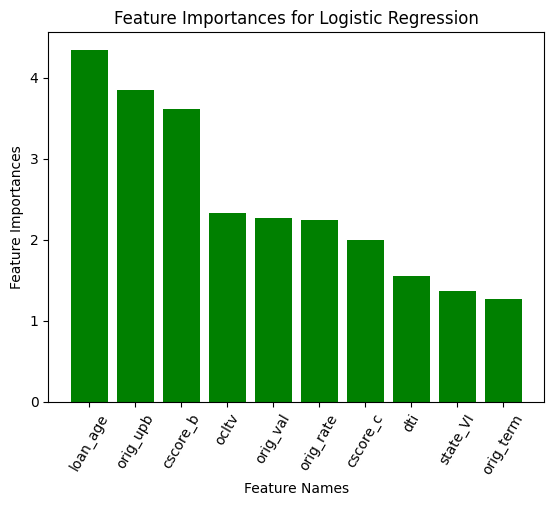

In [94]:
# Get the absolute coefficients of the features
feature_importances = np.abs(log_reg.coef_[0])

# Sort the feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Get the top 10 feature names and importances
top_feature_names = X_train.columns[sorted_indices][:10]
top_feature_importances = feature_importances[sorted_indices][:10]

# Create a bar plot
plt.bar(top_feature_names, top_feature_importances, color='green')
plt.xticks(rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importances')
plt.xticks(rotation=60)
plt.title('Feature Importances for Logistic Regression')
plt.show()

**MODEL EVALUATION**
- Confusion Matrix
- F1 Score
- Area Under the ROC Curve (AUC – ROC)

#### Confusion Matrix

In [95]:
confusion_matrix(y_test, lr_y_prediction)

array([[98767,  1823],
       [22046,  3985]], dtype=int64)

In [96]:
np.bincount(lr_y_prediction)


array([120813,   5808], dtype=int64)

In [97]:
cm_log_reg = confusion_matrix(y_test,lr_y_prediction)
cm_log_reg

array([[98767,  1823],
       [22046,  3985]], dtype=int64)

- **Labels =  'Active' , 'Default'**

**Default** = **1**  
**Active**  = **0**  


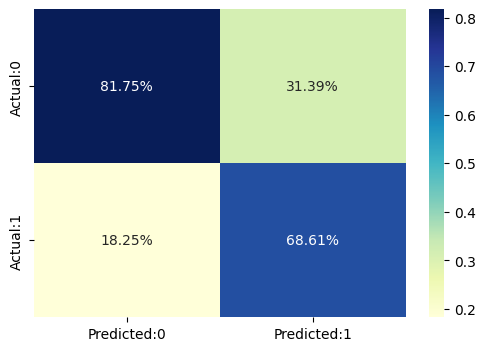

In [98]:
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test,lr_y_prediction, labels=log_reg.classes_)
cm_lr = pd.DataFrame(data=cm_lr,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (6,4))
sns.heatmap(cm_lr/np.sum(cm_lr), annot=True, 
            fmt='.2%' ,cmap="YlGnBu");

- **TN** = 99041  (Predicted False and False in reality)  
- **FP** = 1549   (Predicted True and False in reality)   
- **FN** = 22461  (Predicted False and True in reality)  
- **TP** = 3570   (Predicted True and True in reality)  

In [99]:
print(classification_report(y_test, lr_y_prediction))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89    100590
           1       0.69      0.15      0.25     26031

    accuracy                           0.81    126621
   macro avg       0.75      0.57      0.57    126621
weighted avg       0.79      0.81      0.76    126621



#### ROC curve

In [166]:
from sklearn.metrics import roc_curve, roc_auc_score

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

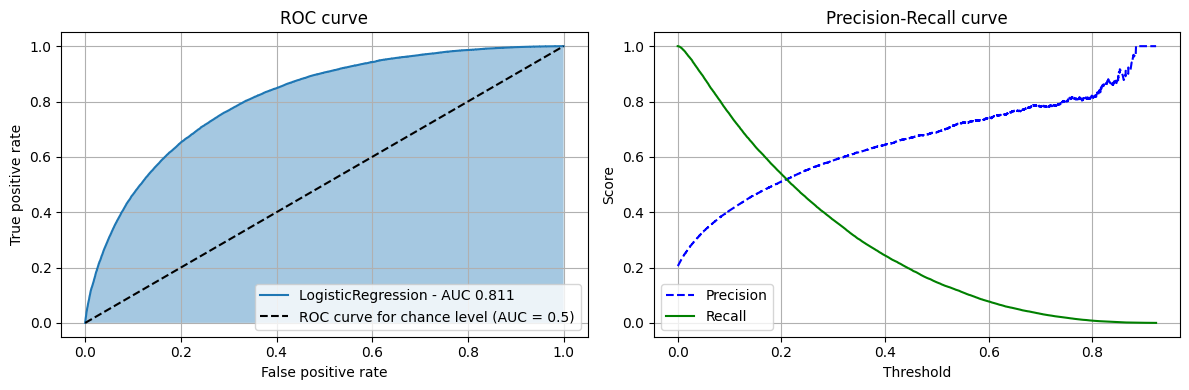

In [254]:
# Calculate ROC curve and AUC for Logistic Regression
y_pred_prob_lr = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = roc_auc_score(y_test, y_pred_prob_lr)

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob_lr)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='LogisticRegression - AUC {:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='ROC curve for chance level (AUC = 0.5)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.fill_between(fpr, tpr, step='pre', alpha=0.4)
plt.title("ROC curve")
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title("Precision-Recall curve")
plt.grid()
plt.tight_layout()
plt.show()


#### Grid Search for Logistic Regression

In [216]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the hyperparameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'random_state': [0, 42]
}

scorer = make_scorer(roc_auc_score)

# If X_train and y_train are DataFrames or Series, convert them to numpy arrays
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy()

# Initialize GridSearchCV for Logistic Regression
kf = TimeSeriesSplit(n_splits=4)

best_score = 0
best_params_lr = None

for penalty in param_grid['penalty']:
    for C in param_grid['C']:
        for random_state in param_grid['random_state']:
            lr = LogisticRegression(penalty=penalty, C=C, random_state=random_state, max_iter=100, solver='liblinear')
            lr.fit(X_train, y_train)

            # Evaluate on the validation set
            valid_score = scorer(lr, X_valid, y_valid)

            # Check if the current model's performance on the validation set is better
            if valid_score > best_score:
                best_score = valid_score
                best_params_lr = {'penalty': penalty, 'C': C, 'random_state': random_state, max_iter=100,solver='liblinear'}

# Train the final model on the entire training data using the best parameters
final_lr = LogisticRegression(**best_params_lr)
final_lr.fit(X_train, y_train)

# Evaluate the final model on the test data
test_score = scorer(final_lr, X_test, y_test)

print("The best score for Logistic Regression on the validation set is {:.3f}".format(best_score))
print("The best parameters for Logistic Regression are:", best_params_lr)
print("The AUC score on the test data: {:.3f}".format(test_score))

The best score for Logistic Regression on the validation set is 0.769
The best parameters for Logistic Regression are: {'penalty': 'l2', 'C': 10, 'random_state': 0}
The AUC score on the test data: 0.567


#### Cross Validate

In [217]:
log_reg = LogisticRegression(max_iter =1000)
kf = KFold(n_splits=4)
scores = cross_val_score(log_reg, X_train, y_train, cv = kf)
scores

array([0.81767238, 0.81719669, 0.81774199, 0.81666299])

**Conclusion**:  
When I checked the score of GridSearch of Logistic Regression, I observed overfitting on model, it means model is too complex that is wht we need do more simplfy the model. If I use logistic regression with default parameters the result seems more accuare. 

### **MODEL: XGBoost**

Perform grid search. You may want to random grid search with k-fold cross validation. Note
that you will do this with the model estimation data set (i.e. full dataset minus hold-out dataset).
When doing cross validation it is advisable to do **time series split based on vintage** as opposed
to random split since you don’t want to train model on future data and test on past data.

In [100]:
from xgboost import XGBClassifier

In [101]:
xgb = XGBClassifier()

In [102]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [103]:
training_score= xgb.score(X_train,y_train) 
print(f'Training Score: {round(training_score,5)}')

Training Score: 0.84506


In [104]:
test_score= xgb.score(X_test,y_test)
print(f'Test Score: {round(test_score,5)}')

Test Score: 0.80871


In [105]:
xgb_y_prediction = xgb.predict(X_test)
xgb_y_prediction

array([0, 0, 0, ..., 0, 0, 0])

####  Feature importances

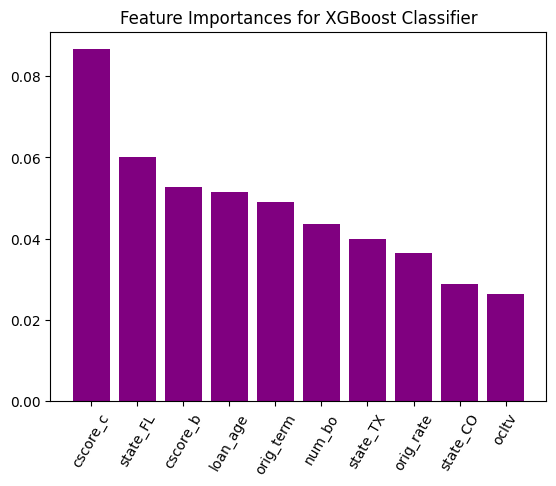

In [114]:
sorted_indices= xgb.feature_importances_.argsort()[::-1]
top_feature_names= X_train.columns[sorted_indices][:10]
top_feature_importances =xgb.feature_importances_[sorted_indices][:10]

plt.bar(top_feature_names,top_feature_importances, color= 'purple')
plt.xticks(rotation= 60)
plt.title('Feature Importances for XGBoost Classifier');

#### XGBoost GridSerachCv

In [121]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((430955, 91), (430955,), (126621, 91), (126621,))

In [122]:
def GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, cv, X, y,n_iter):

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    param_names, param_values = zip(*list(param_grid.items()))
    GS_unvrs_rand=random.sample(list(product(*param_values)), n_iter)
    cv_best_iterations = defaultdict(list)
    cv_results = defaultdict(list)

    for train_index, test_index in cv.split(X, y):
        X_in, X_out = X[train_index], X[test_index]
        y_in, y_out = y[train_index], y[test_index]

        fit_params_cv = deepcopy(fit_params)
        fit_params_cv['eval_set'] = [(X_out, y_out)]

  #      for value_combination in product(*param_values):
        for value_combination in GS_unvrs_rand:
            param_grid_cv = tuple(zip(param_names, value_combination))
            xgboost = XGBClassifier(**dict(param_grid_cv))

            xgboost.fit(X_in, y_in, **fit_params_cv)
            best_iteration = xgboost.get_num_boosting_rounds() if 'early_stopping_rounds' not in fit_params_cv else xgboost.best_iteration
            cv_best_iterations[param_grid_cv].append(best_iteration)

            score = scorer(xgboost, X_out, y_out)
            cv_results[param_grid_cv].append(score)

    best_params_xgb, score_list = max(cv_results.items(), key=lambda x: np.array(x[1]).mean())

    # Note that our XGBoost model may stop early,
    # so we calculate the mean of the actual number of estimators in each fold,
    # in place of the originally planned n_estimators after finishing cross validation.
    n_estimators = int(round(np.array(cv_best_iterations[best_params_xgb]).mean()))

    best_params_xgb = dict(best_params_xgb)
    best_params_xgb['n_estimators'] = n_estimators

    print ("Best score: {:.3f}".format(np.array(score_list).mean()))
    print ("Best Parameters: {}".format(best_params_xgb))

    return best_params_xgb

In [123]:
import numpy as np
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
from collections import defaultdict
import random
from copy import deepcopy

param_grid = {
    'objective': ['binary:logistic'],
    'n_estimators': [1000],
    'max_depth': [2, 5, 7, 9],
    'learning_rate': [0.1, 0.05],
    'random_state': [0,42]
}

fit_params = {
    'eval_metric': "logloss",
    'early_stopping_rounds': 10,
    'verbose': False
}
scorer = make_scorer(roc_auc_score)

kf = TimeSeriesSplit(n_splits=4)
n_iter = 1
best_params_xgb = GridSearchCV_XGB_early_stoppping(param_grid, fit_params, scorer, kf, X_train, y_train, n_iter)

best_xgb = XGBClassifier(**best_params_xgb)

best_xgb.fit(X_train, y_train, eval_metric=fit_params['eval_metric'], verbose=False)
best_score = scorer(best_xgb, X_test, y_test)
print("The best score for XGBoost on validation set is {:.3f}".format(best_score))

Best score: 0.803
Best Parameters: {'objective': 'binary:logistic', 'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.1, 'random_state': 0}
The best score for XGBoost on validation set is 0.545


In [129]:
y_predict_xgb = best_xgb.predict(X_test)
y_predict_xgb.shape

(126621,)

In [130]:
y_predict_train_xgb = best_xgb.predict(X_train)
y_predict_train_xgb

array([0, 0, 0, ..., 0, 0, 1])

In [133]:
from sklearn.metrics import accuracy_score

accuracy_score_xgb_gs = accuracy_score(y_test, y_predict_xgb)
print(f'XGBoost Accuracy Score: {accuracy_score_xgb_gs}')

XGBoost Accuracy Score: 0.8075990554489382


**Conclusion:** 
    After apply gs model is more complex

#### XGBoost Confusion Matrix

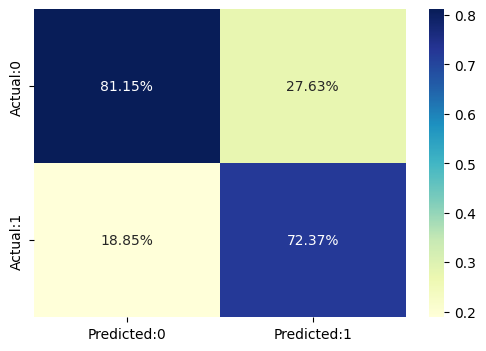

In [134]:
from sklearn.metrics import confusion_matrix
cm_xgb= confusion_matrix(y_test,xgb_y_prediction, labels=xgb.classes_)
cm_xgb = pd.DataFrame(data=cm_xgb,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (6,4))
sns.heatmap(cm_xgb/np.sum(cm_xgb), annot=True, 
            fmt='.2%' ,cmap="YlGnBu");

In [135]:
precision = precision_score(y_test,xgb_y_prediction)
recall = recall_score(y_test,xgb_y_prediction)
f_1_score = f1_score(y_test, xgb_y_prediction)
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f_1_score: {f_1_score}')

precision: 0.7236777063766683
recall: 0.11248127232914602
f_1_score: 0.19470026930877415


In [136]:
y_test.value_counts()

Default
0    100590
1     26031
Name: count, dtype: int64

In [137]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    100590
           1       0.74      0.10      0.17     26031

    accuracy                           0.81    126621
   macro avg       0.77      0.54      0.53    126621
weighted avg       0.80      0.81      0.74    126621



#### ROC Curve XGBoost

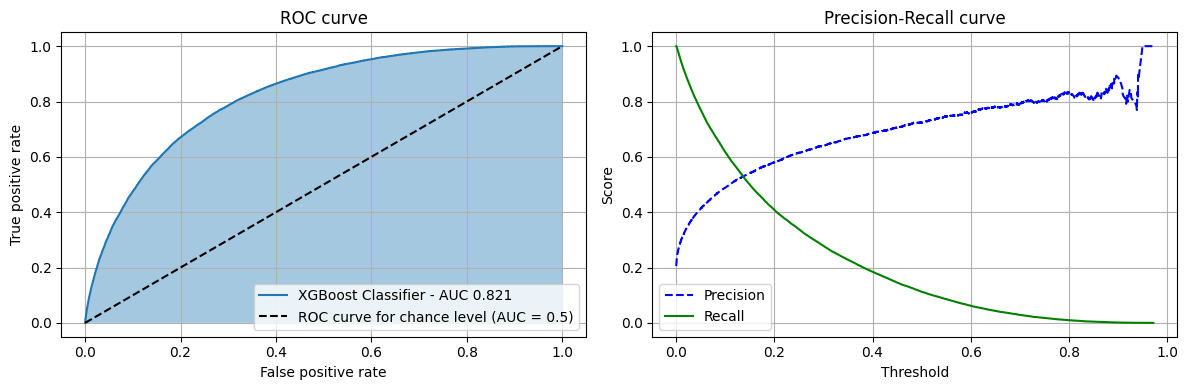

In [138]:
# Calculate ROC curve and AUC for Logistic Regression
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = roc_auc_score(y_test, y_pred_prob_xgb)
# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob_xgb)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='XGBoost Classifier - AUC {:.3f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='ROC curve for chance level (AUC = 0.5)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.fill_between(fpr, tpr, step='pre', alpha=0.4)
plt.title("ROC curve")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title("Precision-Recall curve")
plt.grid()
plt.tight_layout()
plt.show()

### **Model Evaluation**  
- I visualized the predictions and actual default rates by vintage in a plot to observe whether there is any bias in the hold-out dataset.

- Create the plot that you decide at Step 1. ( in this plot you will have two series predicted
probability vs. actual default rate by vintage). Observe any bias on the hold-out dataset.

DataFrame (df):
Use a DataFrame if 'Vintage' is part of a larger dataset with multiple columns, and you want to perform data manipulation, analysis, and visualization on this dataset as a whole.
DataFrames provide powerful tools for data exploration, filtering, aggregation, and merging with other data.

## Plot the Train Data  
- **Before 2014**

In [153]:
train_data['Vintage'].index

Index([     1,      3,      7,      8,      9,     11,     13,     14,     15,
           16,
       ...
       557562, 557563, 557564, 557567, 557568, 557569, 557571, 557572, 557574,
       557575],
      dtype='int64', length=430955)

In [154]:
X_train_1,X_test_1, y_train_1,y_test_1= train_test_split(X_train, y_train, random_state= 0, stratify =y_train, test_size= 0.15)

In [155]:
y_test_1.index.shape

(64644,)

In [156]:
X_train_1.shape,y_train_1.shape,X_test_1.shape,y_test_1.shape

((366311, 91), (366311,), (64644, 91), (64644,))

In [157]:
type(train_data['Vintage'])

pandas.core.series.Series

In [158]:
train_data['Vintage'].shape

(430955,)

In [159]:
from xgboost import XGBClassifier
xgb_before= XGBClassifier()
xgb_before.fit(X_train_1, y_train_1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [160]:
x_predict = xgb_before.predict(X_test_1)
x_predict.shape

(64644,)

In [161]:
y_test_1.shape

(64644,)

In [162]:
train_data['Vintage'].index

Index([     1,      3,      7,      8,      9,     11,     13,     14,     15,
           16,
       ...
       557562, 557563, 557564, 557567, 557568, 557569, 557571, 557572, 557574,
       557575],
      dtype='int64', length=430955)

In [163]:
y_test_1.index

Index([303294,  24198,  20123, 270975,  23000,  26415, 186267, 175517,  73163,
       294540,
       ...
       179028, 348827, 411651, 375328, 402096, 347481, 191388, 247895, 418041,
       173997],
      dtype='int64', length=64644)

In [165]:
train_data.head()

,channel,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,cscore_b,...,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,age_dif,orig_val,Vintage,Prepay,Default
1,R,4.625,328.633535,360.0,9.055440,-0.403892,-0.457299,2.0,48.0,763.0,...,25.0,1.0,N,N,N,2.0,398.526698,2013,0,0
3,C,2.750,626.897121,180.0,2.000250,-1.115887,-1.154291,1.0,15.0,802.0,...,25.0,1.0,N,N,N,2.0,845.307905,2012,0,0
7,R,6.125,324.037035,360.0,3.316776,0.412641,0.346950,2.0,25.0,649.0,...,25.0,1.0,N,N,N,2.0,362.284419,2004,0,0
8,C,5.000,309.838668,360.0,9.643703,-2.074613,-2.081010,1.0,42.0,687.0,...,25.0,1.0,N,N,N,2.0,596.284794,2010,0,1
9,B,6.875,591.607978,360.0,12.328869,-0.278571,-0.334158,2.0,26.0,695.0,...,25.0,1.0,N,N,N,2.0,707.106781,2007,1,0


In [166]:
train_data_reset = train_data.reset_index(drop=True)

if 'Vintage' in train_data_reset.columns:
    test_vint_before = train_data_reset.loc[y_test_1.index, 'Vintage']
    print(test_vint_before)
else:
    print("The 'Vintage' column does not exist in train_data_reset.")
train_data_reset.head()

303294    2006
24198     2003
20123     2003
270975    2008
23000     2009
          ... 
347481    2003
191388    2006
247895    2008
418041    2001
173997    2006
Name: Vintage, Length: 64644, dtype: int64


,channel,orig_rate,orig_upb,orig_term,loan_age,oltv,ocltv,num_bo,dti,cscore_b,...,mi_pct,mi_type,homeready_program_indicator,relocation_mortgage_indicator,high_balance_loan_indicator,age_dif,orig_val,Vintage,Prepay,Default
0,R,4.625,328.633535,360.0,9.055440,-0.403892,-0.457299,2.0,48.0,763.0,...,25.0,1.0,N,N,N,2.0,398.526698,2013,0,0
1,C,2.750,626.897121,180.0,2.000250,-1.115887,-1.154291,1.0,15.0,802.0,...,25.0,1.0,N,N,N,2.0,845.307905,2012,0,0
2,R,6.125,324.037035,360.0,3.316776,0.412641,0.346950,2.0,25.0,649.0,...,25.0,1.0,N,N,N,2.0,362.284419,2004,0,0
3,C,5.000,309.838668,360.0,9.643703,-2.074613,-2.081010,1.0,42.0,687.0,...,25.0,1.0,N,N,N,2.0,596.284794,2010,0,1
4,B,6.875,591.607978,360.0,12.328869,-0.278571,-0.334158,2.0,26.0,695.0,...,25.0,1.0,N,N,N,2.0,707.106781,2007,1,0


In [167]:
test_vint_before = train_data_reset.loc[y_test_1.index, 'Vintage']
test_vint_before.shape

(64644,)

In [168]:
df_train = pd.DataFrame()
df_train['Vintage'] =test_vint_before.values
df_train['Actual_Default_Rate'] = y_test_1.values
df_train['Average_Predicted_Probability'] = x_predict
df_train.head()

,Vintage,Actual_Default_Rate,Average_Predicted_Probability
0,2006,1,1
1,2003,1,1
2,2003,0,0
3,2008,1,1
4,2009,0,0


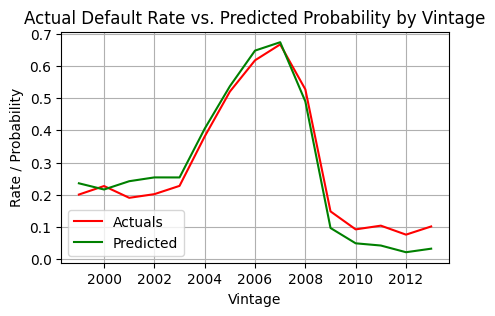

In [169]:
grouped_data_before = df_train.groupby('Vintage').mean()

# Get the vintage values and the corresponding mean values of actual default rate and predicted probability
vintage_before = grouped_data_before.index
actual_default_rate = grouped_data_before['Actual_Default_Rate']
predicted_probability = grouped_data_before['Average_Predicted_Probability']

# Normalize actual_default_rate and predicted_probability to the range [0, 1]
scaler = MinMaxScaler()
grouped_data_before[['Actual_Default_Rate', 'Average_Predicted_Probability']] = scaler.fit_transform(grouped_data_before[['Actual_Default_Rate', 'Average_Predicted_Probability']])

# Create the line plot
plt.figure(figsize= (5,3))
plt.plot(vintage_before,actual_default_rate, label='Actuals', color='red')
plt.plot(vintage_before,predicted_probability, label='Predicted', color='green')
plt.title('Actual Default Rate vs. Predicted Probability by Vintage')
plt.xlabel('Vintage')
plt.ylabel('Rate / Probability')
plt.legend(loc='lower left')
plt.grid()
plt.show()

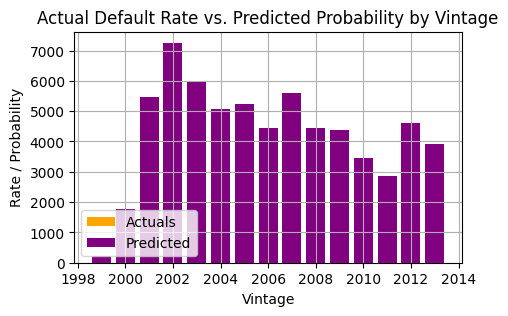

In [170]:
grouped_data_before = df_train.groupby('Vintage').count()
vintage_before = grouped_data_before.index
actual_default_rate = grouped_data_before['Actual_Default_Rate']
predicted_probability = grouped_data_before['Average_Predicted_Probability']

plt.figure(figsize= (5,3))
plt.bar(vintage_before,actual_default_rate, label='Actuals', color='orange')
plt.bar(vintage_before,predicted_probability , label='Predicted', color='purple')
plt.title('Actual Default Rate vs. Predicted Probability by Vintage')
plt.xlabel('Vintage')
plt.ylabel('Rate / Probability')
plt.legend(loc='lower left')
plt.grid()
plt.show()

## Plot the Test Data  
- **After 2014**

In [139]:
xgb_y_prediction 

array([0, 0, 0, ..., 0, 0, 0])

In [140]:
# plot_data = pd.DataFrame()
# plot_data['Vintage'] =test_vint_aft.values
# plot_data['Actual_Default_Rate'] = y_test_1.values
# plot_data['Average_Predicted_Probability'] = xgb_y_prediction
# plot_data.head()

In [141]:
df_aft = pd.DataFrame()
df_aft['Vintage']  = X_holdout['Vintage'].values
df_aft['Actual_Default_Rate'] = y_holdout.values
df_aft['Average_Predicted_Probability'] =xgb_y_prediction 
df_aft.head()

,Vintage,Actual_Default_Rate,Average_Predicted_Probability
0,2017,0,0
1,2016,1,0
2,2020,0,0
3,2014,0,0
4,2017,1,0


In [142]:
X_holdout.shape

(126621, 26)

In [143]:
X_test.shape

(126621, 91)

In [144]:
# Check the column names in grouped_data_aft
print(grouped_data_aft.columns)

Index(['Actual_Default_Rate', 'Average_Predicted_Probability'], dtype='object')


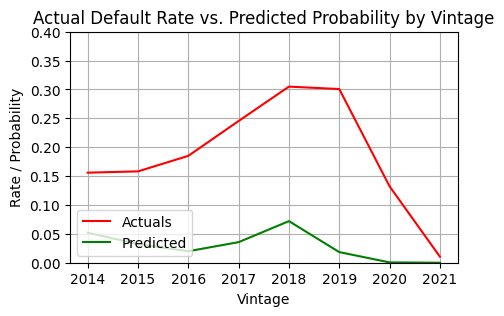

In [145]:
# Group the data by vintage and calculate the mean of actual default rate and predicted probability
grouped_data_aft = df_aft.groupby('Vintage').mean()

# Get the vintage values and the corresponding mean values of actual default rate and predicted probability
vintage_aft = grouped_data_aft.index
actual_default_rate = grouped_data_aft['Actual_Default_Rate']
predicted_probability = grouped_data_aft['Average_Predicted_Probability']

# Create the line plot
plt.figure(figsize= (5,3))
plt.plot(vintage_aft,actual_default_rate, label='Actuals', color='red')
plt.plot(vintage_aft,predicted_probability, label='Predicted', color='green')
plt.ylim(0,0.4)
plt.title('Actual Default Rate vs. Predicted Probability by Vintage')
plt.xlabel('Vintage')
plt.ylabel('Rate / Probability')
plt.legend(loc='lower left')
plt.grid()
plt.show()

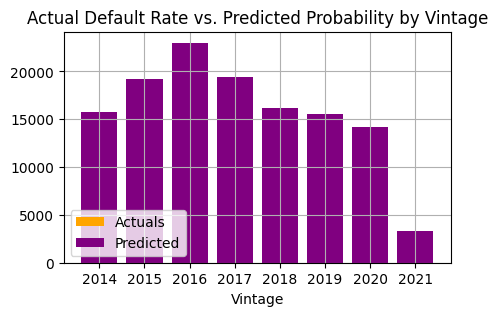

In [148]:
grouped_data_aft =  df_aft.groupby('Vintage').count()
vintage_aft = grouped_data_aft.index
actual_default_rate = grouped_data_aft['Actual_Default_Rate']
predicted_probability = grouped_data_aft['Average_Predicted_Probability']

plt.figure(figsize= (5,3))
plt.bar(vintage_aft,actual_default_rate, label='Actuals', color='orange')
plt.bar(vintage_aft,predicted_probability , label='Predicted', color='purple')
plt.title('Actual Default Rate vs. Predicted Probability by Vintage')
plt.xlabel('Vintage')
#plt.ylabel('Rate / Probability')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [149]:
grouped_data_aft.head()

,Actual_Default_Rate,Average_Predicted_Probability
Vintage,,
2014,15724,15724
2015,19182,19182
2016,23007,23007
2017,19396,19396
2018,16186,16186


## **Conclusion**

In this Mortgage_Default_Project_2, I conducted additional exploratory data analysis (EDA) and feature engineering. My aim was to gain a deeper understanding of the business cycle and insights within the data. When I assessed the model's performance, I found that the accuracy score appeared satisfactory. However, the F1 score was notably low, indicating a significant degree of overfitting.

On the other hand, the ROC-AUC scores and the degree of separation in the data were quite promising. After creating marginal plots, I can confidently say that I trained my model well, as the predicted and actual rate lines closely followed the same trend, especially for the training set.

However, the situation is slightly different for the test set. Even though the model encountered the data for the first time, the lines continue to follow a similar trend. This insight provides valuable information about the model's performance.

**Judging by the F1-scores and the Confusion Matrix, it appears that our model is not well-suited for precise predictions. Nevertheless, when considering plot graphs and the ROC score, we can conclude that the model is effective in distinguishing between classes.**

At this moment, In this project, my model does not know how was the economic situation in USA between 1999-2020 years. This is a crucial information to my model understand insight of loan default risk. As we know, mortgage loans are moslty used for purchasing homes. In light of this focus on the Mortgage Loan Project, I have decided to incorporate House Price Indexes and unemployment rate datasets and evaluate the results. You can find all the details in my Mortgage_Default_Project_3.